# Taller II: Implementing a simple ASR system using HMM

En este taller implementaremos un sistema de reconocimiento automatico de habla, utilizando modelos ocultos de markov. Para este taller se puede utilizar la libreria [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#customizing) de Python. Este taller será parte de la nota del proyecto de evaluación del primer corte. Así que se deberá entregar al finalizar la semana 5 junto con el desarrollo del proyecto de evaluación.

En este taller implementaremos un sistema de reconocimiento de habla de palabras aisladas. Esto quiere decir que hay una separación entre cada palabra pronunciada, y no se utilizará  habla fluida continua. La idea es implementar un sistema sencillo con un vocabulario limitado, para qu epuedan entender el principio de funcionamiento de estos sistemas. Para este taller deben seguir lso siguientes pasos:

1. Cree un diccionaro pequeño compuesto de alrededor de 20 palabras. Si desean incluir más palabras no hay problema.
2. Cada una de estas palabras dividalas en fonemas. Asigne a cada fonema un número para facilitar su identificación.
3. Grabé cada una de las palbaras de forma aislada. 
4. Para cada señal de voz grabada calcule el mel espectrograma utilizando 39 componentes (este es el estandar que usan los sistemas modernos).
5. Identifique las secciones del mel spectrograma que corresponden a cada fonema.
6. Modele la distribución de los vectores del Mel espectrograma para cada fonema, esto puede hacerlo usando GMM (Gaussian Mixture Models).
7. Calcule la matrix de probabilidades de transición utilizando el diccionario que ustedes crearón.
8. Implemente el modelo HMM.
9. Pruebe con los datos de entrenamiento si el modelo produce la secuencia de fonemas indicada.
10. Genere un nuevo conjunto de palabras (al menos 10) que se conformen con los fonemas presentes en su diccionario. A partir de la señal de voz de cada una de estas nuevas palabras, trate de predecir la palbara escrita utilizando el modelo implementado.

**NOTA:** Trate de Utilizar fonemas que tengan una única relación con letras (silabas) del alfabeto. Esto disminuirá la tasa de error del modelo.

1. Fecha -> /f/e/ch/a/
2. Libro -> /l/i/b/r/o
3. Lapiz -> /l/a/p/i/c
4. Correr -> /k/o/rr/e/r
5. Telefono -> /t/e/l/e/f/o/n/o
6. Puerta -> /p/u/e/r/t/a
7. Pantalla -> /p/a/n/t/a/ll/a
8. Ximena -> /j/i/m/e/n/a
9. Regla -> /r/e/g/l/a
10. Billetera -> /b/i/ll/e/t/e/r/a
11. Zapato -> /c/a/p/a/t/o
12. Jamón -> /j/a/m/o/n/
13. kiosko -> /k/i/o/s/k/o
14. baloncesto -> /b/a/l/o/n/c/e/s/t/o
15. murcielago -> /m/u/r/c/i/e/l/a/g/o
16. muchacho -> /m/u/ch/a/ch/o
17. ahijado -> /a/ /i/j/a/d/o
18. Terremoto -> /t/e/rr/e/m/o/t/o
19. Llorar -> /ll/o/r/a/r
20. espantapajaro -> /e/s/p/a/n/t/a/p/a/j/a/r/o

## Clasificacion de fonemas:

1. /a/ -> a -> 1
2. /b/ -> b,v,w(depende) -> 2
3. /c/ -> c(ante e,i),z(ante a,o,u) -> 3
4. /ch/ -> ch -> 4
5. /d/ -> d ->5
6. /e/ -> e -> 6
7. /f/ -> f -> 7
9. /g/ -> g (ante a,o,u const), gu(ante e i) -> 8
10. // -> h -> 9
11. /i/ -> i,y -> 10
12. /j/ -> g(ante e,i) j(vocales) -> 11
13. /k/ -> c (ante a, o, u o consontante) qu (ante e, i), k -> 12
14. /l/ -> l ->13
15. /ll/ -> ll ->14
16. /m/ -> m -> 15
17. /n/ -> n ->16
18. /ñ/ -> ñ -> 17
19. /o/ -> o -> 18
20. /p/ ->p ->19
21. /r/-> r (arena) -> 20
22. /rr/-> (arriba) -> 21
23. /s/ -> s -> 22
24. /t/ -> t -> 23
25. /u/ -> u -> 24
26. /x/ -> x -> 25
27. /y/ -> y -> 26




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy as sc
from scipy import signal
from scipy.fft import fftshift

import pandas as pd

import librosa
import librosa.display

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import soundfile as sf
import os

from sklearn.mixture import GaussianMixture

In [2]:
fs = 8000 # Numero de muestras por segundo
nBits = 16 # Numero de bits por muestra del audio
ID = -1
seconds = 5 # Duracion de la grabacion
Nfft = 512
fm = np.arange(0, Nfft / 4) * fs / Nfft

In [3]:
nombres = os.listdir('./utils/sounds/')
nombres

['ahijado.wav',
 'balocesto.wav',
 'espantapajaro.wav',
 'jamon.wav',
 'kiosko.wav',
 'llorar.wav',
 'muchacho.wav',
 'murcielago.wav',
 'sound1.wav',
 'sound10.wav',
 'sound2.wav',
 'sound3.wav',
 'sound4.wav',
 'sound5.wav',
 'sound6.wav',
 'sound7.wav',
 'sound8.wav',
 'sound9.wav',
 'terremoto.wav',
 'zapato.wav']

In [4]:
#cantidad_fonemas = [7,10,13,5,6,5,6,10,4,8,5,5,5,8,6,7,6,5,8,6] # Aumentamos en 2 para considerar los fonemas del silencio
cantidad_fonemas = [9,12,15,7,8,7,8,12,6,10,7,7,7,10,8,9,8,7,10,8]
dicc = {}
for idx,i in enumerate(nombres):
    dicc[i] = cantidad_fonemas[idx]
dicc

{'ahijado.wav': 9,
 'balocesto.wav': 12,
 'espantapajaro.wav': 15,
 'jamon.wav': 7,
 'kiosko.wav': 8,
 'llorar.wav': 7,
 'muchacho.wav': 8,
 'murcielago.wav': 12,
 'sound1.wav': 6,
 'sound10.wav': 10,
 'sound2.wav': 7,
 'sound3.wav': 7,
 'sound4.wav': 7,
 'sound5.wav': 10,
 'sound6.wav': 8,
 'sound7.wav': 9,
 'sound8.wav': 8,
 'sound9.wav': 7,
 'terremoto.wav': 10,
 'zapato.wav': 8}

In [5]:
def getAudios(nombres):
    audios = []
    for i in nombres:
        y_aux, fs_aux = sf.read('./utils/sounds/' + i)
        if len(y_aux.shape) > 1:
            y_aux = y_aux[:,0]
            y = ((1/np.std(y_aux))*y_aux).reshape(len(y_aux))
        else:
            y = ((1/np.std(y_aux))*y_aux).reshape(len(y_aux))
        audios.append(y)
    return audios

In [6]:
def getMelSpectogram(audios,fs,Nfft):
    spectograms = []
    for i in audios:
        Sm = librosa.feature.melspectrogram(y=i, sr=fs, n_fft=Nfft, n_mels = 39)
        spectograms.append(Sm)
    return spectograms

In [7]:
audios = getAudios(nombres)

In [8]:
Spectograms = getMelSpectogram(audios,fs,Nfft)

C:\Users\juanc\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\juanc\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\juanc\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


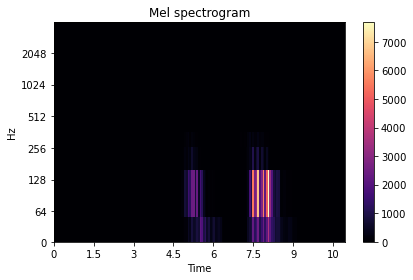

In [9]:
# Graficando diversos espectogramas
Sm = Spectograms[0]
fig=plt.figure()
#librosa.display.specshow(Sm,y_axis='mel',x_axis='time')
librosa.display.specshow(Sm, sr=fs, hop_length=Nfft, x_axis='time', y_axis='log')
plt.colorbar() #Confirmar unidad
plt.title("Mel spectrogram")
plt.tight_layout()

In [10]:
def getVectorErrores(Spectograms):
    DSms = []
    for i in Spectograms:
        D_Sm = np.sqrt(np.sum((i[:,1:] - i[:,0:-1])**2,axis=0))
        DSms.append(D_Sm)
    return DSms

In [11]:
DSms = getVectorErrores(Spectograms)

In [12]:
Spectograms[0].shape

(39, 171)

In [13]:
y_aux, fs_aux = sf.read('./utils/sounds/' + 'ahijado.wav')
sd.play(y_aux,fs_aux)

64


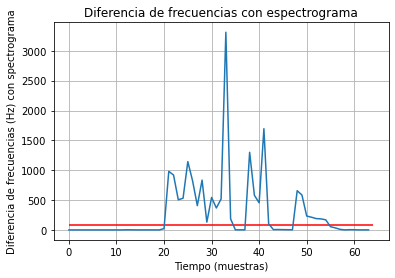

In [14]:
D_Sw = DSms[1]
print(len(D_Sw))
fig = plt.figure()
plt.grid(True)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia de frecuencias (Hz) con spectrograma") # REVISAR
plt.title("Diferencia de frecuencias con espectrograma")
plt.plot(D_Sw)
plt.hlines(80, xmin = 0, xmax = len(D_Sw), colors = 'r')

In [15]:
aux = D_Sw[D_Sw > 100]

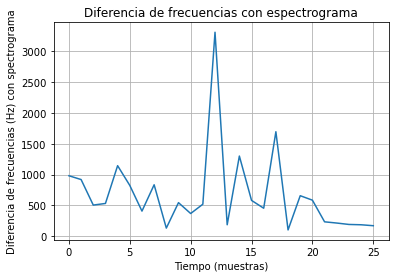

In [16]:
fig = plt.figure()
plt.grid(True)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia de frecuencias (Hz) con spectrograma") # REVISAR
plt.title("Diferencia de frecuencias con espectrograma")
plt.plot(aux);

In [17]:
def getFonemas(DSms, dicc_fonemas, nombres):
    epsilon = 50
    fonemas = []
    for idx,i in enumerate(DSms):
        j_I = 0
        while (i[j_I] < epsilon):
            j_I += 1
        j_D = len(i) - 1
        while (i[j_D] < epsilon):
            j_D -= 1
        if j_I - 10 > 0:
            j_I = j_I - 10
        if j_D + 10 < len(i):
            j_D = j_D + 10
        i_palabra = range(j_I,j_D + 1)
        num_fonemas = dicc_fonemas[nombres[idx]]
        fonemas.append(np.array_split(i_palabra,num_fonemas))
        #fonemas.append(i_palabra)
    return fonemas

In [18]:
fonemas = getFonemas(DSms, dicc, nombres)
fonemas

[[array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73]),
  array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
  array([84, 85, 86, 87, 88, 89, 90, 91, 92, 93]),
  array([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103]),
  array([104, 105, 106, 107, 108, 109, 110, 111, 112, 113]),
  array([114, 115, 116, 117, 118, 119, 120, 121, 122, 123]),
  array([124, 125, 126, 127, 128, 129, 130, 131, 132, 133]),
  array([134, 135, 136, 137, 138, 139, 140, 141, 142, 143]),
  array([144, 145, 146, 147, 148, 149, 150, 151, 152])],
 [array([11, 12, 13, 14]),
  array([15, 16, 17, 18]),
  array([19, 20, 21, 22]),
  array([23, 24, 25, 26]),
  array([27, 28, 29, 30]),
  array([31, 32, 33, 34]),
  array([35, 36, 37, 38]),
  array([39, 40, 41, 42]),
  array([43, 44, 45, 46]),
  array([47, 48, 49]),
  array([50, 51, 52]),
  array([53, 54, 55])],
 [array([50, 51, 52, 53, 54, 55, 56, 57, 58]),
  array([59, 60, 61, 62, 63, 64, 65, 66, 67]),
  array([68, 69, 70, 71, 72, 73, 74, 75, 76]),
  array([77, 78, 79, 80, 81, 82

In [19]:
fonemas[8]

[array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]),
 array([112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]),
 array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133]),
 array([134, 135, 136, 137, 138, 139, 140, 141, 142, 143]),
 array([144, 145, 146, 147, 148, 149, 150, 151, 152, 153]),
 array([154, 155, 156, 157, 158, 159, 160, 161, 162, 163])]

In [20]:
# Construccion del modelo GMM
# totalFonemas = 22
# spectogramas: lista de los espectogramas
# Fonemas: lista de fonemas (inidices)

def getModelGMM(fonemas, spectogramas, totalFonemas):
    bandera = True
    for idx,palabra in enumerate(fonemas):
        spectograma = spectogramas[idx]
        matrix_aux = spectograma[:,palabra[0][0]:palabra[0][-1]]
        for i in range(1,len(palabra)):
            fonema = palabra[i]
            subMatrix = spectograma[:,fonema[0]:fonema[-1]]
            matrix_aux = np.concatenate((matrix_aux, subMatrix), axis = 1)
        if bandera:
            matrix_model = matrix_aux
            bandera = False
        else:
            matrix_model = np.concatenate((matrix_model,matrix_aux), axis = 1)
    
    matrix_final = matrix_model.T
    gm = GaussianMixture(n_components=totalFonemas, random_state=0).fit(matrix_final)
    return gm,matrix_model

In [21]:
modelo, matrix_datos = getModelGMM(fonemas,Spectograms,22)

In [22]:
modelo

GaussianMixture(n_components=22, random_state=0)

## Proceso para armar la matriz de transicion

1. Hacer la codificacion para cada uno de los fonemas de las palabras.
2. Calcular el numero de ocurrencia de cada uno de los fonemas de las palabras.
3. Para cada uno de los 22 fonemas calcular la probabilidad condicional dada P(fonema actual | fonema anterior).
4. Verificar que la suma de valores en cada fila sea igual a 1.
5. Armar la matriz de transición de tamaño (22 $\times$ 22)

Agregamos el **codigo 0 asociado a silencio al comienzo y al final** de cada lista de codigos de fonemas. Esto se justifica dado que al comienzo y al final de cada palabra hay un silencio así sea breve.

In [23]:
# orden segun como se leyeron los audios de la base de datos
palabras_codificadas = [[1,9,10,11,1,5,18], [2,1,13,18,16,3,6,22,23,18],[6,22,19,1,16,23,1,19,1,11,1,20,18],
                        [11,1,15,18,16],[12,10,18,22,12,18], [14,18,20,1,20],[15,24,4,1,4,18],[15,24,20,3,10,6,13,1,8,18],
                        [7,6,4,1], [2,10,14,6,23,6,20,1],[13,10,2,20,18],[13,1,19,10,3],[12,18,21,6,20],[23,6,13,6,7,18,16,18],
                        [19,24,6,20,23,1],[19,1,16,23,1,14,1],[11,10,15,6,16,1],[21,6,8,13,1],[23,6,21,6,15,18,23,18],[3,1,19,1,23,18]]  

In [24]:
for p in palabras_codificadas:
    p.insert(0,0)
    p.append(0)

In [25]:
dicc_countFon = {}
for i in range(0,27):
    ocurrencia = 0
    for j in palabras_codificadas:
        ocurrencia += j.count(i)
    dicc_countFon[i] = ocurrencia

In [26]:
dicc_countFon

{0: 40,
 1: 22,
 2: 3,
 3: 4,
 4: 3,
 5: 1,
 6: 14,
 7: 2,
 8: 2,
 9: 1,
 10: 7,
 11: 4,
 12: 3,
 13: 6,
 14: 3,
 15: 5,
 16: 6,
 17: 0,
 18: 17,
 19: 6,
 20: 8,
 21: 3,
 22: 3,
 23: 9,
 24: 3,
 25: 0,
 26: 0}

In [27]:
# Si se quiere descartar columna y fila de 0s retornar dataframe con probs[1:,1:] 
def getMatrizTrans(palabras_codificadas, dicc_countFon):
    # lista de fonemas presentes
    fonemas_pre = [f for f in dicc_countFon.keys() if  dicc_countFon[f] != 0]
    N = len(fonemas_pre)
    print(N)
    # Matriz de probabilidades de transicion de tamaño NxN
    probs = np.zeros([N,N])
    for i in range(N):
        # Fijamos el codigo del fonema
        f = fonemas_pre[i]
        #print("Ocurrencias de fonema "+str(f)+": ",dicc_countFon[f])
        # Para cada fonema tenemos un diccionario que cuenta la cantidad de veces que aparece una letra despues de f
        counts = dict()
        # inicializacion de las cuentas en 0
        for p in fonemas_pre:
            counts[p] = 0
        for cods in palabras_codificadas:
            #indice posiciones donde esta el fonema f en cada sublista
            idx_pre = [k for k in range(len(cods)) if cods[k] == f]
            # Vamos a buscar en cada lista de codigos de fonemas, si  cods[k] esta despues de f
            if len(idx_pre) > 0:
                # En este caso aparece al menos una vez el fonema de interes
                for pos in idx_pre:
                    # aumentamos en 1 las veces que aparece el fonema con codigo cods[pos+1]
                    counts[cods[(pos+1)%len(cods)]] +=1
        # llenamos la fila en la matriz asociada al codigo del fonema f
        c = 0 # contador para las columnas
        # Se llena la i-esima fila de la matriz
        for j in counts.keys():
            probs[i,c] = float(counts[j])/dicc_countFon[f] + 0.1
            c += 1
        # verificacion de que la suma de valores en la i-esima fila sea igual a 1
        # la suma no da exactamente 1
        probs[i,:] = (1/np.sum(probs[i,:])) * probs[i,:]
        assert abs(np.sum(probs[i,:]) - 1) < 0.99999, "Las probabilidades en la fila "+ str(i) + " no suman 1"
    df = pd.DataFrame(probs,index=fonemas_pre,columns=fonemas_pre)
    return df


## Obtención de los datos de la media y la desviación estandar para cada fonema.

In [28]:
def agruparFonemas(lista_fonemas, palabras,dicc_fonemas, espectogramas):
    # lista_fonemas : lista de listas con los indices de cada fonema en una palabra.
    # palabras: lista de listas de fonemas codificados por palabra.
    # dicc_fonemas: diccionario con (codigo fonema, ocurrencia en todas la palbras).
    # espectogramas: lista de los espectogramas de las palabras.
    # Esta función retorna una lista de matrices en la cual cada matriz tiene las columnas 
    # de un mismo fonema dada toas las palabras.
    cods_fonemas = [f for f in dicc_fonemas.keys() if dicc_fonemas[f] != 0]
    print(len(cods_fonemas))
    lista_matrices = []
    for f in cods_fonemas:
        print("f: ", f)
        bandera = True
        for idx,palabra in enumerate(palabras):
            print("palabra:" , palabra)
            if f in palabra:
                indices = []
                for i in range(len(palabra)):
                    #print("i:", i)
                    #print("palabra[i]",palabra[i])
                    if f == palabra[i]:
                        indices.append(i)
                print("indices: " , indices)
                fonemas = lista_fonemas[idx]
                print("fonemas: ", fonemas)
                espectograma = espectogramas[idx]
                for indice in indices:
                    fon = fonemas[indice]
                    colums_fonema = espectograma[:,fon]
                    if bandera:
                        matriz_fon = colums_fonema
                        bandera = False
                    else:    
                        matriz_fon = np.concatenate([matriz_fon,colums_fonema], axis = 1)
        lista_matrices.append(matriz_fon)
        #print("----------------------------")
    return lista_matrices

In [29]:
matrices_fonemas = agruparFonemas(fonemas, palabras_codificadas, dicc_countFon, Spectograms)

24
f:  0
palabra: [0, 1, 9, 10, 11, 1, 5, 18, 0]
indices:  [0, 8]
fonemas:  [array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73]), array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83]), array([84, 85, 86, 87, 88, 89, 90, 91, 92, 93]), array([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103]), array([104, 105, 106, 107, 108, 109, 110, 111, 112, 113]), array([114, 115, 116, 117, 118, 119, 120, 121, 122, 123]), array([124, 125, 126, 127, 128, 129, 130, 131, 132, 133]), array([134, 135, 136, 137, 138, 139, 140, 141, 142, 143]), array([144, 145, 146, 147, 148, 149, 150, 151, 152])]
palabra: [0, 2, 1, 13, 18, 16, 3, 6, 22, 23, 18, 0]
indices:  [0, 11]
fonemas:  [array([11, 12, 13, 14]), array([15, 16, 17, 18]), array([19, 20, 21, 22]), array([23, 24, 25, 26]), array([27, 28, 29, 30]), array([31, 32, 33, 34]), array([35, 36, 37, 38]), array([39, 40, 41, 42]), array([43, 44, 45, 46]), array([47, 48, 49]), array([50, 51, 52]), array([53, 54, 55])]
palabra: [0, 6, 22, 19, 1, 16, 23, 1, 19, 1, 11, 1, 20, 18

       117]), array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]), array([131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143])]
palabra: [0, 15, 24, 4, 1, 4, 18, 0]
palabra: [0, 15, 24, 20, 3, 10, 6, 13, 1, 8, 18, 0]
palabra: [0, 7, 6, 4, 1, 0]
palabra: [0, 2, 10, 14, 6, 23, 6, 20, 1, 0]
indices:  [3]
fonemas:  [array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40]), array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62]), array([63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
       80, 81, 82, 83, 84]), array([ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106]), array([107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128]), array([129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143,

In [30]:
def repairFonemas(matrices_fonemas):
    nuevas_matrices = []
    for fonema in matrices_fonemas:
        matriz_nueva = fonema
        columna = fonema.shape[1]
        if columna < 39:
            media = np.mean(fonema,axis = 1)
            covarianza = np.cov(fonema)
            vec_necesarios = 39 - columna
            for i in range(vec_necesarios):
                aleatorio = np.reshape(np.random.multivariate_normal(media,covarianza),(39,1))
                matriz_nueva = np.concatenate([matriz_nueva,aleatorio],axis = 1)
        nuevas_matrices.append(matriz_nueva)
    return nuevas_matrices

In [31]:
nuevas_matrices = repairFonemas(matrices_fonemas)

In [32]:
def getMediaVarianza(matrices_fonemas):
    lista_medias = []
    lista_cov = []
    for matriz in matrices_fonemas:
        media = np.mean(matriz, axis = 1)
        cov_aux = np.cov(matriz)
        lista_medias.append(media)
        lista_cov.append(cov_aux)
    return lista_medias, lista_cov

In [33]:
medias, cov = getMediaVarianza(nuevas_matrices)

In [34]:
# Si arroja verdadero es port que no es definida positiva
def is_pos_def(x):
    #return np.any(np.linalg.eigvals(x) > 0)
    return np.any(np.linalg.eigvalsh(x) <= 0)

for i in cov:
    print(is_pos_def(i))

False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True


In [35]:
def repairCov(lista_cov,c):
    nueva_cov = []
    for matriz in lista_cov:
        if is_pos_def(matriz):
            nueva_matriz = matriz + np.eye(39) * c
            nueva_cov.append(nueva_matriz)
        else:
            nueva_cov.append(matriz)
    return nueva_cov

In [36]:
cov_nueva = repairCov(cov,2)

In [37]:
for i in cov_nueva:
    print(is_pos_def(i))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [38]:
# Ahora volviendo tensor las matrices de covarianza
covarianza = np.zeros((len(cov_nueva),39,39))
for i in range(len(cov_nueva)):
    covarianza[i,:,:] = cov_nueva[i]

In [39]:
covarianza.shape

(24, 39, 39)

In [40]:
medias_nuevas = np.concatenate([medias], axis = 1)
medias_nuevas.shape

(24, 39)

# Preguntas alex

1. El calculo de las medias y las covarianzas se hacen sumando filas o sumando columnas.
2. Como se hace para que las matrices de covarianzas sean definidas positivas.
3. Las redes hacen clustering o clasificación.
4. Que hacer en caso de que no funciones con las medias y varianzas manueales.

In [41]:
# MAtriz de probabilidades de transicion para Modelos de Markov y predecir palabra (NO HMM)
matrix_trans = getMatrizTrans(palabras_codificadas, dicc_countFon)

24


In [42]:
matrix_trans

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,18,19,20,21,22,23,24
0,0.176471,0.036765,0.044118,0.036765,0.029412,0.029412,0.036765,0.036765,0.029412,0.029412,...,0.036765,0.044118,0.029412,0.029412,0.044118,0.029412,0.036765,0.029412,0.044118,0.029412
1,0.109626,0.029412,0.029412,0.029412,0.042781,0.042781,0.029412,0.029412,0.042781,0.042781,...,0.042781,0.042781,0.056150,0.029412,0.069519,0.056150,0.029412,0.029412,0.042781,0.029412
2,0.029412,0.127451,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.127451,0.029412,0.029412,0.029412,0.029412
3,0.102941,0.102941,0.029412,0.029412,0.029412,0.029412,0.102941,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
4,0.029412,0.225490,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.127451,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
5,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.323529,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
6,0.029412,0.029412,0.029412,0.029412,0.050420,0.029412,0.029412,0.050420,0.050420,0.029412,...,0.029412,0.050420,0.050420,0.029412,0.029412,0.092437,0.050420,0.071429,0.050420,0.029412
7,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.176471,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.176471,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
8,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.176471,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
9,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412


In [43]:
def getStartprobs(dicc,palabras_codificadas):
    vector = []
    fonemas_pre = [f for f in dicc.keys() if  dicc_countFon[f] != 0]
    N = len(fonemas_pre)
    for i in range(N):
        f = fonemas_pre[i]
        count = 0
        for palabra in palabras_codificadas:
            count += palabra.count(f)
        prob = count/np.sum([dicc[k] for k in dicc.keys()])
        vector.append(prob)
    return vector

In [44]:
startprob = getStartprobs(dicc_countFon, palabras_codificadas)
np.sum(startprob)

1.0

In [45]:
from hmmlearn import hmm

ModuleNotFoundError: No module named 'hmmlearn'

In [ ]:
model = hmm.GaussianHMM(n_components=len(startprob), covariance_type="full")
model.startprob_ = startprob
model.transmat_ = matrix_trans
model.means_ = medias_nuevas
model.covars_ = covarianza

In [ ]:
model.predict(Spectograms[0].T)

In [ ]:
# Diccionario de fonemas a numero
# Basados en: https://www.livingspanish.com/correspondencia-fonetica-grafia.htm
dic_fon = {"/a/":1, "/b/":2, "/c/":3, "/ch/":4, "/d/":5,
           "/e/":6, "/f/":7, "/g/":8, "//":9, "/i/":10,
           "/j/":11, "/k/":12, "/l/":13, "/m/":14, "/n/":15,
           "/ñ/":16, "/o/":17, "/p/":18, "/rr/":19, "/s/":20,
           "/t/":21, "/u/":22, "/x/":23, "/y/":24, "/ll/":25,
           "/r/":26
}